In [1]:
import jax.random
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload

%cd /mnt/c/Users/Habush/PycharmProjects/bnn_bg
from s3.helper_functions import *
from s3.mcmc_functions import *
from core.spike_slab import *

/mnt/c/Users/Habush/PycharmProjects/bnn_bg


2024-01-13 18:44:48.863056: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
%autoreload
from s3.helper_functions import synthetic_data
n = 500

p = 1000
s0 = 10
seed = 5
synth_data = synthetic_data(seed, n, p, s0, random_index=False)

x, y, true_beta, true_beta_idx = synth_data["X"], synth_data["y"], synth_data["true_beta"], synth_data["true_beta_idx"]
print(f"true beta idx: {true_beta_idx}")

true beta idx: [0 1 2 3 4 5 6 7 8 9]


In [4]:
from utils.tree_utils import tree_stack, tree_unstack
import time
from core.spike_slab import *
from s3.mcmc_functions import *
from tqdm import tqdm

def run_spike_slab_inference(seeds, x, y, true_beta_idx, mlp_fn, 
                             n_iterations=2000, burn_in=1000):
    mixed_gibbs_chains = {"z": [], "beta": [], "sigma2": []}
    s3_chains = {"z": [], "beta": [], "sigma2": []}
    
    params = spike_slab_params(n, p, type="linear")
    tau0, tau1 = params["tau0"], params["tau1"]
    a0, b0 = params["a0"], params["b0"]
    q = params["q"]
    
    step_sizes = {"z": 0.5, "beta": 0.1,  "sigma2": 1e-5}
    time_elapsed = {"mixed_gibbs": [], "s3": []}
    metrics = {"fpr": {"mixed_gibbs": [], "s3": []}, 
               "tpr": {"mixed_gibbs": [], "s3": []}}
    
    for seed in tqdm(seeds):
        t1 = time.time()
        gibbs_samples = spike_slab_inference(seed=seed, step_sizes=step_sizes, 
                               tau0=tau0, tau1=tau1, a0=a0, b0=b0, q=q,
                               x=x, y=y, mlp_fn=mlp_fn,
                               n_iters=n_iterations, burn_in=burn_in, show_progress=False)
        t2 = time.time()
        
        mixed_gibbs_chains["z"].append(gibbs_samples["z"])
        mixed_gibbs_chains["beta"].append(gibbs_samples["beta"])
        mixed_gibbs_chains["sigma2"].append(gibbs_samples["sigma2"])
        
        time_elapsed["mixed_gibbs"].append(t2-t2)
        
        gibbs_fpr = fpr(gibbs_samples["z"], p, true_beta_idx)
        gibbs_tpr = tpr(gibbs_samples["z"], true_beta_idx)
        
        metrics["fpr"]["mixed_gibbs"].append(gibbs_fpr)
        metrics["tpr"]["mixed_gibbs"].append(gibbs_tpr)
        
        t1 = time.time()
        s3_samples = spike_slab_linear(chain_length=2000, X=x, y=y, 
                                 rinit=None, verbose=False, 
                                 burnin=1000, store=True, **params)
        t2 = time.time()
        
        s3_chains["z"].append(s3_samples["z"])
        s3_chains["beta"].append(s3_samples["beta"])
        s3_chains["sigma2"].append(s3_samples["sigma2"])
        
        time_elapsed["s3"].append(t2-t1)
        
        s3_fpr = fpr(s3_samples["z"], p, true_beta_idx)
        s3_tpr = tpr(s3_samples["z"], true_beta_idx)
        
        metrics["fpr"]["s3"].append(s3_fpr)
        metrics["tpr"]["s3"].append(s3_tpr)
        
    return mixed_gibbs_chains, s3_chains, time_elapsed, metrics

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

In [7]:
%autoreload
from core.spike_slab import *
def mlp_fn(x, beta):
    return x @ beta

params = spike_slab_params(n, p, type="linear")
tau0, tau1 = params["tau0"], params["tau1"]
# a0, b0 = params["a0"], params["b0"]
q = params["q"]
a0, b0 = 0.0, 1.0
print(params)
step_sizes = {"z": 0.5, "beta": 1e-3,  "sigma2": 1e-4}
prior_scale = 1.0
samples, accept_probs = spike_slab_inference(seed=seed, step_sizes=step_sizes, 
                               tau0=tau0, tau1=tau1, a0=a0, b0=b0, q=q,
                               x=x_train, y=y_train, mlp_fn=mlp_fn,
                               n_iters=2000, burn_in=1000, 
                               show_progress=True, mh=True, const_schedule=False)

# z, beta, sigma2 = np.array(samples["z"]), np.array(samples["beta"]), jax.nn.softplus(np.array(samples["sigma2"]))
z, beta, sigma2 = samples["z"], samples["beta"], jax.nn.softplus(samples["sigma2"])
# print(f"Num samples: {len(beta)}")
# print(f"Mean accept prob: {np.mean(accept_prob)}")
print(f"Mean accept probs: beta: {np.mean(accept_probs['beta'])}, z: {np.mean(accept_probs['z'])}, sigma2: {np.mean(accept_probs['sigma2'])}")

{'q': 0.007, 'tau0': 0.044721359549995794, 'tau1': 1.0, 'a0': 1.0, 'b0': 1.0}


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:11<00:00, 180.02it/s]


Mean accept probs: beta: 0.02576888657347217, z: 0.5, sigma2: 0.49951052057743073


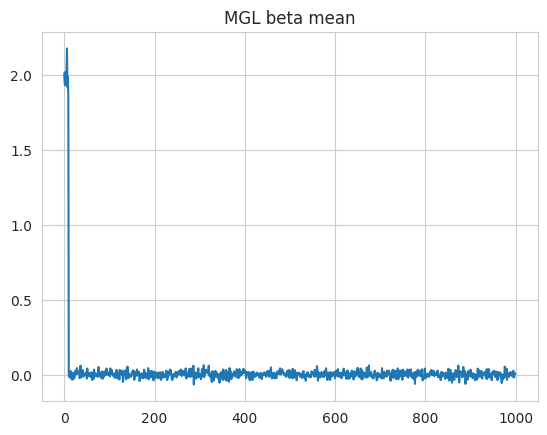

In [8]:
plt.plot(np.mean(beta, axis=0))
plt.title("MGL beta mean")
plt.show()

tpr: 1.0, fpr: 0.0


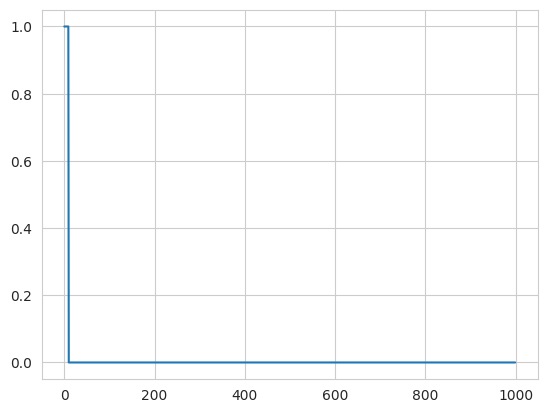

In [9]:
print(f"tpr: {tpr(z, true_beta_idx)}, fpr: {fpr(z, p, true_beta_idx)}")
plt.plot(np.mean(z, axis=0))
plt.show()

0.6419731


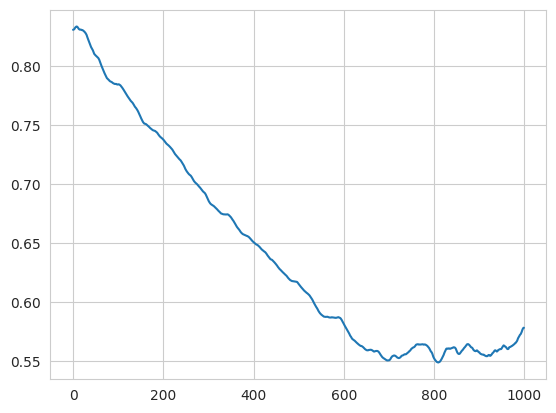

In [10]:
print(np.mean(sigma2))
plt.plot(sigma2)
plt.show()

In [11]:
%autoreload
from s3.mcmc_functions import *
s3_chain_output = spike_slab_linear(chain_length=2000, X=x_train, y=y_train, 
                                 rinit=None, verbose=True, 
                                 burnin=1000, store=True, **params)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 229.51it/s]


tpr: 1.0, fpr: 0.0


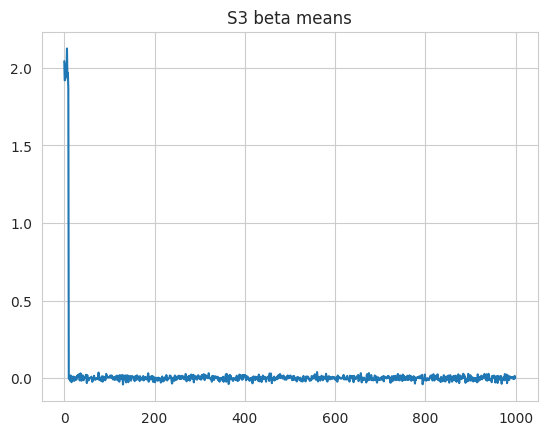

In [14]:
print(f"tpr: {tpr(s3_chain_output['z'], true_beta_idx)}, fpr: {fpr(s3_chain_output['z'], p, true_beta_idx)}")
plt.plot(np.mean(s3_chain_output["beta"], axis=0))
plt.title("S3 beta means")
plt.show()

0.4660713738170363


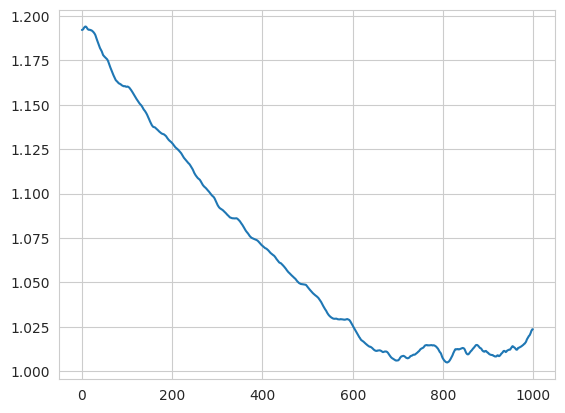

In [13]:
print(np.mean(s3_chain_output["sigma2"]))
plt.plot(jax.nn.softplus(sigma2))
plt.show()

In [ ]:
%autoreload
from core.spike_slab import *
def mlp_fn(x, beta):
    return x @ beta

seeds = [42, 0, 745, 88, 129]
n_iter, burn_in = 2000, 1000
samples_per_chain = n_iter - burn_in 
mixed_gibbs_chains, s3_chains, time_elapsed, metrics =  run_spike_slab_inference(seeds, x, y, true_beta_idx, mlp_fn, 
                                                                                 n_iterations=n_iter, burn_in=burn_in)

In [ ]:
mgl_beta_samples = np.array(mixed_gibbs_chains["beta"])
s3_beta_samples = np.array(s3_chains["beta"])
ess_mgl = [tfp.mcmc.effective_sample_size(mgl_beta_samples[i]) for i in range(len(seeds))]
ess_s3 = [tfp.mcmc.effective_sample_size(s3_beta_samples[i]) for i in range(len(seeds))]
print(f"ess_mgl: {np.mean(ess_mgl)} +/- {np.std(ess_mgl)}\n"
      f"ess_s3 = {np.mean(ess_s3)} +/- {np.std(ess_s3)}")

In [ ]:
## TODO Add FPR & TPR plots
print(metrics["fpr"])
print(metrics["tpr"])

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

total_samples = len(seeds)*samples_per_chain
ax1.plot(np.mean(mgl_beta_samples.reshape(total_samples, -1), axis=0))

ax1.set_title("Mean of Beta samples from MGL")

ax2.plot(np.mean(s3_beta_samples.reshape(total_samples, -1), axis=0))
ax2.set_title("Mean of Beta samples from S3")

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

total_samples = len(seeds)*samples_per_chain
ax1.plot(np.mean(np.array(mixed_gibbs_chains["z"]).reshape(total_samples, -1), axis=0))

ax1.set_title("Mean of z samples from MGL")

ax2.plot(np.mean(np.array(s3_chains["z"]).reshape(total_samples, -1), axis=0))
ax2.set_title("Mean of z samples from S3")

In [ ]:
time_elapsed_data = np.vstack([np.array(time_elapsed["mixed_gibbs"]), np.array(time_elapsed["s3"])]).T
plt.boxplot(time_elapsed_data, vert=True, 
            patch_artist=True, labels=["mixed_gibbs", "s3"])
plt.title("Time elapsed per chain (in seconds)")
plt.show()

### Logistic regression

In [377]:
%autoreload
from s3.helper_functions import synthetic_data
n = 100
p = 1000
s0 = 10

seed = 0

synth_data_log = synthetic_data(seed,
                                n, p, s0, type="logistic", 
                                random_index=True) #with random indices

x_log, y_log, true_beta_log, true_beta_idx_log = (synth_data_log["X"], synth_data_log["y"], 
                                                  synth_data_log["true_beta"], 
                                    synth_data_log["true_beta_idx"])
print(f"true beta idx: {true_beta_idx_log}")

true beta idx: [ 61  21  91 372 409 338 572 767 278 352]


In [ ]:
%autoreload
from core.spike_slab import *
from s3.mcmc_functions import *

def mlp_fn(x, beta):
    return x @ beta

params = spike_slab_params(n, p, type="linear")
tau0, tau1 = params["tau0"], params["tau1"]
a0, b0 = params["a0"], params["b0"]
q = params["q"]

step_sizes = {"z": 0.5, "beta": 0.1,  "sigma2": 0.1}
mgl_samples = spike_slab_inference(seed=seed, step_sizes=step_sizes, 
                               tau0=tau0, tau1=tau1, a0=a0, b0=b0, q=q,
                               x=x_log, y=y_log, mlp_fn=mlp_fn, binary=True,
                               n_iters=2000, burn_in=1000, show_progress=True)

s3_samples = spike_slab_logistic(chain_length=2000, X=x_log, y=y_log, 
                                 tau0=tau0, tau1=tau1, q=q,
                                 rinit=None, verbose=False, 
                                 burnin=1000, store=True)

z_mgl, beta_mgl = mgl_samples["z"], mgl_samples["beta"]
z_s3, beta_s3 = s3_samples["z"], s3_samples["beta"]

In [ ]:
#Draw mean value for beta and z side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
ax1.plot(np.mean(beta_mgl, axis=0))
ax1.set_title("Mean of Beta samples")
ax2.plot(np.mean(z_mgl, axis=0))
ax2.set_title("Mean of z samples")
ax2.axhline(y=0.5, xmin=0, xmax=p, color="red", linestyle="--", label="p=0.5") #selection threshold
ax2.legend()
print(f"fp rate: {fpr(z_mgl, p, true_beta_idx_log)}\n"
      f"tp rate: {tpr(z_mgl, true_beta_idx_log)}")
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
ax1.plot(np.mean(beta_s3, axis=0))
ax1.set_title("Mean of Beta samples")
ax2.plot(np.mean(z_s3, axis=0))
ax2.set_title("Mean of z samples")
ax2.axhline(y=0.5, xmin=0, xmax=p, color="red", linestyle="--", label="p=0.5") #selection threshold
ax2.legend()
print(f"fp rate: {fpr(z_s3, p, true_beta_idx_log)}\n"
      f"tp rate: {tpr(z_s3, true_beta_idx_log)}")
plt.show()

### Riboflavin Data
Source - Buhlmann et al. (2014)

In [2]:
import pandas as pd

data_path = "/mnt/c/Users/Habush/PycharmProjects/bnn_bg/data"
riboflavin = pd.read_csv(f"{data_path}/riboflavin.csv")
riboflavin_y = riboflavin['y'].to_numpy()
riboflavin_x = riboflavin.drop(['y','Unnamed: 0'], axis=1).to_numpy()
riboflavin.shape

(71, 4090)

In [4]:
%autoreload
from sklearn.model_selection import train_test_split
from core.spike_slab import *
from s3.helper_functions import *
def mlp_fn(x, beta):
    return x @ beta


seeds = [420]
# seeds = [42]
accept_probs_per_chain = []
n_iter = 3000
burn_in = 1000
num_chains = 1

rmses = {"mgl": [], "s3": []}

per_chain_samples = {"mgl": {"z": [], "beta": [], "sigma2": []}, 
      "s3": {"z": [], "beta": [], "sigma2": []}}

step_sizes = {"z": 0.01, "beta": 1e-3,  "sigma2": 1e-3}

for seed in tqdm(seeds):
    riboflavin_x_train, riboflavin_x_test, riboflavin_y_train, riboflavin_y_test = train_test_split(riboflavin_x, 
                                                                                                    riboflavin_y, 
                                                                                                    test_size=0.2, 
                                                                                                    random_state=seed)
    
    per_chain_samples = {"mgl": {"z": [], "beta": [], "sigma2": []}, 
      "s3": {"z": [], "beta": [], "sigma2": []}}
    
    
    n, p = riboflavin_x_train.shape
    
    params = spike_slab_params(n, p, type="linear")
    tau0, tau1 = params["tau0"], params["tau1"]
    q = params["q"]
    # a0, b0 = params["a0"], params["b0"]
    a0, b0 = 0.0, 0.1
    tau0, tau1 = 1e-2, 0.1
    # print(f"params: {params}")
    for c in range(num_chains):
        accept_probs_per_chain = {"mgl": {"z": [], "beta": [], "sigma2": []}}
        # mgl_samples, accept_probs = spike_slab_inference(seed=seed, step_sizes=step_sizes, 
        #                            tau0=tau0, tau1=tau1, a0=a0, b0=b0, q=q,
        #                            x=riboflavin_x_train, y=riboflavin_y_train, mlp_fn=mlp_fn,
        #                            n_iters=n_iter, burn_in=burn_in, show_progress=False, 
        #                                                  mh=True, const_schedule=True, prior_scale=1.0)

        s3_samples = spike_slab_linear(chain_length=n_iter, X=riboflavin_x_train, y=riboflavin_y_train, 
                                     rinit=None, verbose=False, 
                                     burnin=burn_in, store=True, **params)
        
        
        # per_chain_samples["mgl"]["z"].append(mgl_samples["z"])
        # per_chain_samples["mgl"]["beta"].append(mgl_samples["beta"])
        # per_chain_samples["mgl"]["sigma2"].append(mgl_samples["sigma2"])
        # 
        # #update accept probs
        # accept_probs_per_chain["mgl"]["z"].append(accept_probs["z"])
        # accept_probs_per_chain["mgl"]["beta"].append(accept_probs["beta"])
        # accept_probs_per_chain["mgl"]["sigma2"].append(accept_probs["sigma2"])

        per_chain_samples["s3"]["z"].append(s3_samples["z"])
        per_chain_samples["s3"]["beta"].append(s3_samples["beta"])
        per_chain_samples["s3"]["sigma2"].append(s3_samples["sigma2"])
        # 
        # print(f"Mean accept probs: beta: {np.sum(accept_probs['beta'])/(n_iter-burn_in)}, "
        #       f"z: {np.sum(accept_probs['z'])/(n_iter-burn_in)}, "
        #       f"sigma2: {np.sum(accept_probs['sigma2'])/(n_iter-burn_in)}")
        # print(f"Num samples: {len(mgl_samples['beta'])}")
    
    # beta_mgl_samples = np.array(per_chain_samples["mgl"]["beta"]).reshape(-1, p)
    beta_s3_samples = np.array(per_chain_samples["s3"]["beta"]).reshape(-1, p)
    # print(f"beta shape: {beta_mgl_samples.shape}")
    
    beta_mean_s3 = np.mean(beta_s3_samples, axis=0)
    # beta_mean_mgl = np.mean(beta_mgl_samples, axis=0)
    
    # y_test_pred_mgl = mlp_fn(riboflavin_x_test, beta_mean_mgl)
    # rmse_mgl = np.sqrt(np.mean((y_test_pred_mgl - riboflavin_y_test)**2))
    
    y_test_pred_s3 = mlp_fn(riboflavin_x_test, beta_mean_s3)
    rmse_s3 = np.sqrt(np.mean((y_test_pred_s3 - riboflavin_y_test)**2))
    
    # rmses["mgl"].append(rmse_mgl)
    rmses["s3"].append(rmse_s3)
    # print(f"rmse_mgl: {rmse_mgl}")
    print(f"rmse s3: {rmse_s3}")
    # print(f"rmse_mgl: {rmse_mgl}\n"
    #       f"rmse_s3: {rmse_s3}")

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.15s/it]

rmse s3: 0.5731803400739187


/home/xabush/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/xabush/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


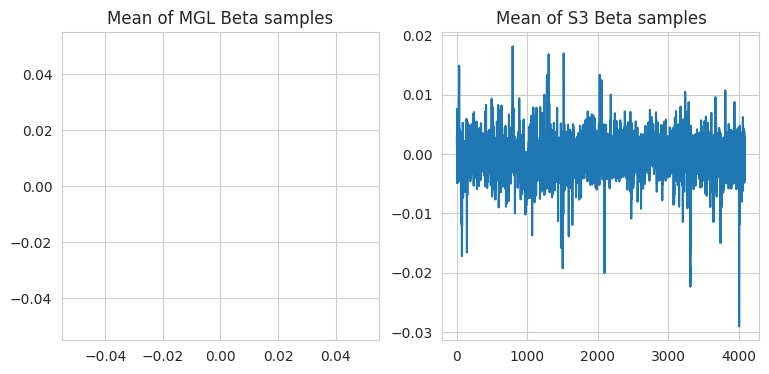

In [5]:
beta_mgl_samples = np.array(per_chain_samples["mgl"]["beta"]).reshape(-1, p)
beta_s3_samples = np.array(per_chain_samples["s3"]["beta"]).reshape(-1, p)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
ax1.plot(np.mean(beta_mgl_samples, axis=0))
ax1.set_title("Mean of MGL Beta samples")
ax2.plot(np.mean(beta_s3_samples, axis=0))
ax2.set_title("Mean of S3 Beta samples")
plt.show()

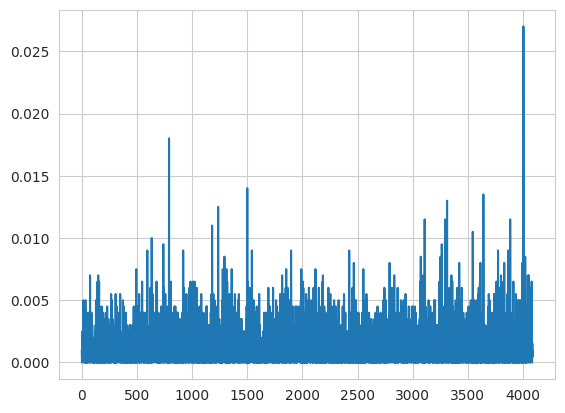

In [8]:
z_s3_samples = np.array(per_chain_samples["s3"]["z"]).reshape(-1, p)
z_s3_mean = np.mean(z_s3_samples, axis=0)
plt.plot(z_s3_mean)
plt.show()

In [9]:
np.argsort(z_s3_mean)[::-1]

array([4003,  791, 1500, ..., 3037, 1429, 2363])

sigma2_s3: 0.08796673229341016 +/- 0.01823333718165266
sigma2_mgl: 1.0177712440490723 +/- 0.0020296485163271427


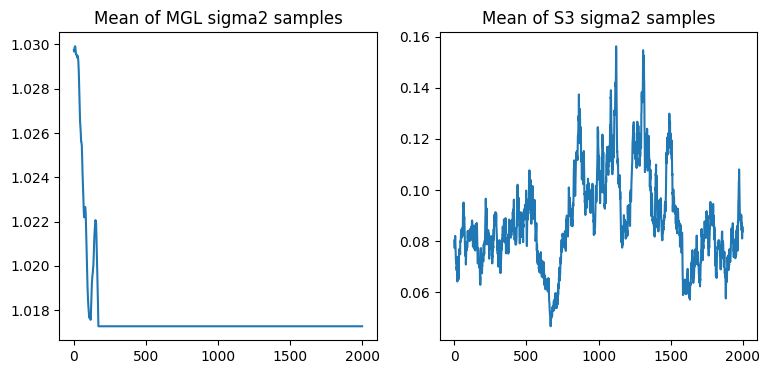

In [45]:
num_samples = len(per_chain_samples["mgl"]["sigma2"])
sigma2_mgl_samples = jax.nn.softplus(np.array(per_chain_samples["mgl"]["sigma2"])).reshape(num_chains, -1)
sigma2_s3_samples = np.array(per_chain_samples["s3"]["sigma2"]).reshape(num_chains*(n_iter-burn_in), -1)

print(f"sigma2_s3: {np.mean(sigma2_s3_samples)} +/- {np.std(sigma2_s3_samples)}")
print(f"sigma2_mgl: {np.mean(sigma2_mgl_samples)} +/- {np.std(sigma2_mgl_samples)}")

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
ax1.plot(sigma2_mgl_samples.T)
ax1.set_title("Mean of MGL sigma2 samples")
ax2.plot(sigma2_s3_samples)
ax2.set_title("Mean of S3 sigma2 samples")
plt.show()

In [46]:
z_mgl_samples = np.array(per_chain_samples["mgl"]["z"]).reshape(-1, p)
z_s3_samples = np.array(per_chain_samples["s3"]["z"]).reshape(-1, p)
z_mean_mgl = np.mean(z_mgl_samples, axis=0)
sorted_indices_mgl = np.argsort(z_mean_mgl)[::-1]
z_mean_mgl_sorted = z_mean_mgl[sorted_indices_mgl]
z_stds_mgl = (np.var(z_mgl_samples, axis=0)/len(seeds))**0.5
z_mean_s3 = np.mean(z_s3_samples, axis=0)
sorted_indices_s3 = np.argsort(z_mean_s3)[::-1]
z_mean_s3_sorted = z_mean_s3[sorted_indices_s3]
z_stds_s3 = (np.var(z_s3_samples, axis=0)/len(seeds))**0.5

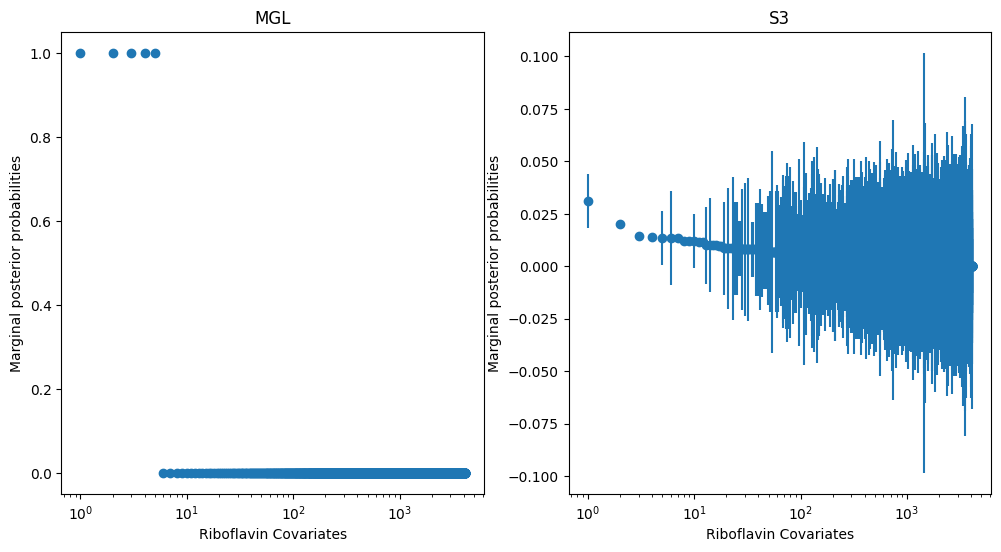

In [47]:
#Draw z mean and stds for mgl and s3 side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax1.errorbar(x=np.arange(len(z_mean_mgl_sorted))+1, y=z_mean_mgl_sorted, yerr=z_stds_mgl,fmt='o')
ax1.set_title("MGL")
ax1.set_xscale('log')
ax1.set_xlabel('Riboflavin Covariates')
ax1.set_ylabel('Marginal posterior probabilities')
ax2.errorbar(x=np.arange(len(z_mean_s3_sorted))+1, y=z_mean_s3_sorted, yerr=z_stds_s3,fmt='o')
ax2.set_title("S3")
ax2.set_xscale('log')
ax2.set_xlabel('Riboflavin Covariates')
ax2.set_ylabel('Marginal posterior probabilities')
plt.show()

In [48]:
sorted_indices_mgl

array([2307, 1426, 1415, ..., 2719, 2718,    0])

In [278]:
sorted_indices_s3

array([4003, 3764, 4001, ..., 1906, 1909,    0])